In [28]:
import numpy as np 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt 
import seaborn as sns 

In [22]:
# This class implements a linear classifier with a common prediction function for linear clfs 
class LinearClassifier: 
    def __init__(self): 
        self.weights = None
        self.positive_class = None
        self.negative_class = None
        # Initialize the fitted state to False
        self.is_fitted_ = False
        
    def find_classes(self, Y): 
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of classes
        is not 2, an error is raised since it is a linear classfier it can only handle 2 classes
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("Must be a 2-class problem!")
        self.positive_class = classes[0]
        self.negative_class = classes[1]
    
    def predict(self, X):
        """
        Predicts the class of the input data X.
        Assumes that X is a NumPy matrix where each row contains the features for one instance.
        """
        # Compute scores as the dot product of X and the weights
        scores = np.dot(X, self.weights)
        # Return the class based on the score
        choices_array = np.array([self.negative_class, self.positive_class], dtype=object)

        predicted_class = np.select(
            [scores < 0, scores >= 0],
            choices_array,
            default=self.negative_class 
        )
        
        return predicted_class

In [23]:
# Implementing the perceptron algorithm
class Perceptron(LinearClassifier):
    def __init__(self, n_epochs=10):
        """
        Initializes the Perceptron with a specified number of epochs.
        """
        super().__init__() 
        self.n_epochs = n_epochs
         
                    
    def fit(self, X, Y):
        """
        Trains the linear classifier using the Perceptron on training set (X,Y)
        """
        # Determine which output classes will be positive and negative
        self.find_classes(Y)

        # Convert string labels to numerical for Perceptron:
        # Perceptron updates typically use +1 for positive class and -1 for negative class.
        Y_numeric = np.array([1 if y == self.positive_class else -1 for y in Y])

        # Initialize weight vector to zero weights
        self.weights = np.zeros(X.shape[1])

        # Perform the training
        for epoch in range(self.n_epochs):
            errors = 0 # Count errors to check for convergence
            # Iterate over all instances in the training set
            for i in range(len(X)):
                x = X[i]
                y_true_numeric = Y_numeric[i] # Use numerical true label

                # Compute the score
                score = np.dot(x, self.weights)

                # Prediction
                if y_true_numeric * score <= 0: 
                    # Update weights
                    self.weights += y_true_numeric * x 
                    errors += 1
            if errors == 0: # If no errors in an epoch, it has converged
                break
            
        self.is_fitted_ = True

        

In [24]:
# Test on the adult dataset 

def read_names(filename):
    names = [] # Initialize an empty list to store column names
    types = [] # Initialize an empty list to store column types 
    with open(filename) as f:
        for l in f: # Iterate through each line (l) in the file
            if l[0] == '|' or ':' not in l: 
                continue    # Skip lines that are comments or don't define an attribute
            
            cols = l.split(':')
            names.append(cols[0])
            
            # Determine the data type based on the description after the colon
            if cols[1].startswith(' continuous.'):
                types.append(float)
            else:
                types.append(str)
    return names, types

col_names, col_types = read_names('data/adult.names')

def read_data(filename, col_names, col_types):
    X = []
    Y = []
    with open(filename) as f:
        for l in f:
            cols = l.strip('\n.').split(', ')
            if len(cols) < len(col_names):
                continue
            X.append( { n:t(c) for n, t, c in zip(col_names, col_types, cols) } )
            Y.append(cols[-1])
    return X, Y

# read the training set
Xtrain, Ytrain = read_data('data/adult.data', col_names, col_types)

# read the test set
Xtest, Ytest = read_data('data/adult.test', col_names, col_types)

#Print the input and output for the first instance
# input consists of a feature dictionary
# output is a string either ' <=50K' or ' >50K'
from pprint import pprint

pprint(Xtrain[0])
print("---")
print(Ytrain[0])

{'age': 39.0,
 'capital-gain': 2174.0,
 'capital-loss': 0.0,
 'education': 'Bachelors',
 'education-num': 13.0,
 'fnlwgt': 77516.0,
 'hours-per-week': 40.0,
 'marital-status': 'Never-married',
 'native-country': 'United-States',
 'occupation': 'Adm-clerical',
 'race': 'White',
 'relationship': 'Not-in-family',
 'sex': 'Male',
 'workclass': 'State-gov'}
---
<=50K


In [25]:
# Create pipeline for training and testing the perceptron
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [34]:
# Use one-hot encoding for categorical features
# Use sparse = false since the perceptron assumes examples are stored in NumPy matrix
dv = DictVectorizer(sparse=False)

# Normalize the data with StandardScaler
scaler = StandardScaler(with_mean=False)

clf = Perceptron()

pipeline = make_pipeline(dv, scaler, clf)   
pipeline.fit(Xtrain, Ytrain)
Yguess = pipeline.predict(Xtest)
print("Accuracy on test set: ", accuracy_score(Ytest, Yguess))

# Precision, Recall, F1-Score (often summarized by classification_report)
class_labels = sorted(list(set(Ytest))) # Get unique sorted class labels

print("\nClassification Report:")
print(classification_report(Ytest, Yguess, target_names=class_labels))

Accuracy on test set:  0.7913956978489245

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.91      0.81      0.86      1518
        >50K       0.55      0.73      0.63       481

    accuracy                           0.79      1999
   macro avg       0.73      0.77      0.74      1999
weighted avg       0.82      0.79      0.80      1999



#### Negative class <=50K: 

##### Precision - Out of all the instances that the model predicted as <=50K, 91% were actually true 
##### Recall - Out of all the instances that actually were <=50K, 81% were identified by the model 
##### F1 (harmonic mean of precision and recall) - 0.86 is quite good  

#### Positive class >50K:

##### Precision - Out of all the instances that the model predicted as >50K, only 55% were actually true. Have a lot of false positives 
##### Recall - Out of all the instances that actually were >50K, 73% were identified by the model
##### F1 - low score of 0.63 meaning that the model struggles more with the positive class due to lower precision  


Confusion Matrix:
[[1230  288]
 [ 129  352]]


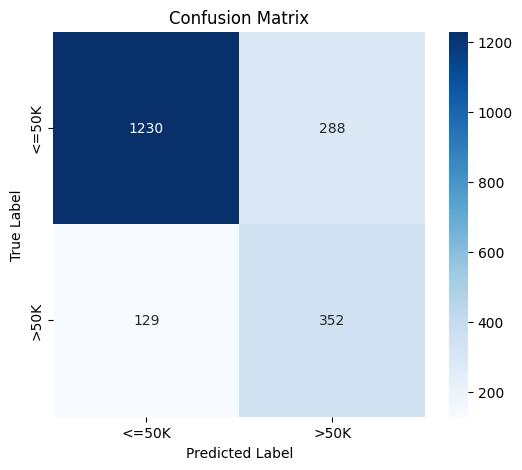

In [ ]:
cm = confusion_matrix(Ytest, Yguess, labels=class_labels) 

print("\nConfusion Matrix:")
print(cm)

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Why low precision on positive class?


##### 'Support' term for <=50K is 1518 and for >50K is 481. This is a clear imbalance. The negative class (<=50K) is roughly 3 times larger than the positive class (>50K). Addionally Perceptron (and many linear models) tend to be biased towards the majority class. Also note that the FP (top right) is almost as big as TP (bottom right). Adding class weighting to the fit method would be a good choice to tackle the class imbalance (to some extent).